## Gender Bias  Classification as a Foundation for Headline Objectivity

Madeline F. Birch | November 2023 |

# Contents
1. [Project Overview](#Project_Overview)
2. [The Dataset](#The_Dataset)
3. [Exploratory Data Analysis](#EDA)
4. [Feature Engineering](#Feature_Engineering)
5. [Preprocessing](#Preprocessing)
6. [Train Test Split](#Train_Test_Split)
7. [Modeling](#Modeling)
8. [Findings](#Findings)
9. [Recommendations](#Recommendations)

# Project Overview<a id='Project_Overview'></a>

In an era where information shapes perspectives, the media plays a pivotal role in influencing societal narratives. Understanding the subtle nuances and potential biases embedded in headlines is crucial, and this project aims to shed light on the degree of bias present in headlines. Focusing on data classification through machine learning, the project seeks to predict headlines into three classes: No Bias, Low Bias, and High Bias. The objective is not to scrutinize sensationalism or analyze sentiment polarity but rather to leverage textual and numerical features to predict the bias level accurately.

<img src="Images/pbs_logo.png" alt="PBS Logo" width="400"/>

### Our Stakeholder: PBS News
The significance of this project lies in its potential impact on journalism's objectivity, particularly for PBS News, a revered American news source known for its impartiality and lack of apparent agenda. Publicly funded by 15%, the entity continuously [faces accusations](https://www.vanityfair.com/hollywood/2018/02/donald-trump-budget-pbs-public-media-spending-cuts) of general bias and [threats of defunding from various actors](https://www.nytimes.com/2011/02/28/business/media/28cpb.html). 

By adopting insights gained from our efforts, PBS News can *silence these threats* and *secure its value* as a trusted source for objective, unbiased headlines.

### Our Vision: Gender Bias in Headlines as a Framework
We chose to focus on gender bias as a focus for this project because it is undeniably one of the most prevalent forms of bias in published news content. A 2021 Topic Modeling [study](https://www.frontiersin.org/articles/10.3389/frai.2021.664737/full) found women are unfortunately but not unexpectedly *mentioned* "more frequently in topics related to lifestyle, healthcare, and crimes and sexual assault." Another 2021 Natural Language Processing [study](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0245533) concluded, "although
we see a certain tokenism in having female *voices* present in the news, their voices are drowned
out by the overwhelming number of times that we hear from men, often from just a handful of
men." There's no denying that gender bias is present in news article content, both in references toward and quotations credited to women, but what about the content of *headlines?* Couldn't headlines about women be biased, too?

At the heart of this initiative is the recognition of headlines as powerful agents that shape our perceptions. These succinct phrases captivate our attention and mold our subconscious understanding of entire articles. The urgency to prove and maintain neutrality, especially on a platform as eminent as PBS, underscores the relevance of our undertaking.

While our primary focus is on demonstrating which ML algorithms are most adept at detecting gender bias in headlines, this project could serve a framework for ongoing assessments of headlines across diverse bias types, including political, racial, LGBTQ+, socioeconomic class and beyond. The broader vision is to contribute to a media landscape characterized by transparency, objectivity, and accountability, fostering a public discourse grounded in fair and unbiased reporting.

<img src="Images/women_in_headlines.png" alt="Headlines" width="400"/>

# The Dataset<a id='The_Dataset'></a>

The dataset utilized in this project originates from a comprehensive collection of data scraped for ["When Women Make Headlines,"](https://pudding.cool/2022/02/women-in-headlines/) a visual essay published by [*The Pudding*](https://pudding.cool/) in June 2022. Released by [Amber Thomas](https://data.world/amberthomas) on [data.world](https://data.world/the-pudding/women-in-headlines), this dataset is one of few open source datasets we could find that investigates gender bias specifically in headlines. It encompasses a diverse array of headlines about women, each annotated with corresponding bias scores. Bias scores were calculated following the methodology outlined in ["Proposed Taxonomy for Gender Bias in Text; A Filtering Methodology for the Gender Generalization Subtype."](https://aclanthology.org/W19-3802.pdf)

The dataset's origin in a visual essay adds an element of real-world applicability, grounding the project in the practical considerations of media consumption and perception. Its richness lies in its amalgamation of both textual numerical features associated with each headline. The text data provides the linguistic context of the headlines, while numerical features offer additional dimensions for analysis. This holistic approach enables the development of a machine learning model that can discern patterns beyond linguistic constructs, contributing to a nuanced understanding of what contributes to bias. 

### Our Working File
The dataset contains a multitude of `.csv` files; for the sake of simplicity, we will be working exclusively with `headlines.csv` and engineering additional numerical features to bolster our models.

### Our Target
Our target variable will be `bias`.

# Exploratory Data Analysis<a id='EDA'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import datetime
from nltk.corpus import stopwords
import gensim
import gensim.downloader
from gensim.utils import simple_preprocess

In [2]:
# Loading 'headlines.csv' into a Pandas DataFrame
headlines = pd.read_csv('Data/headlines.csv')

# Showing first 5 rows of the DataFrame
headlines.head()

,index,Unnamed: 0,url,headline_no_site,site,time,country,bias
0,0,0,https://www.iol.co.za/entertainment/movies-the...,'Lady Bird' buzzes through young sexuality,iol.co.za,2018-02-23 08:00:00+00:00,South Africa,0.000000
1,1,1,https://www.iol.co.za/entertainment/music/the-...,The shadowy urban POP super Starrah who loves ...,iol.co.za,2018-01-10 08:00:00+00:00,South Africa,0.166667
2,2,2,https://www.iol.co.za/entertainment/celebrity-...,Rihanna pens heartfelt tribute to her mom in b...,iol.co.za,2018-02-21 08:00:00+00:00,South Africa,0.333333
3,3,3,https://www.iol.co.za/news/south-africa/wester...,Shock as woman accused of killing teen girlfri...,iol.co.za,2018-02-27 08:00:00+00:00,South Africa,0.333333
4,4,4,https://www.iol.co.za/business-report/careers/...,TOP STORY: Meet South Africa's new first lady ...,iol.co.za,2018-02-15 08:00:00+00:00,South Africa,0.166667


In [3]:
# Dropping irrelevant columns 'url', 'Unnamed: 0', and 'index'
headlines = headlines.drop(columns=['url', 'Unnamed: 0', 'index'])

In [4]:
# Getting the shape of our DataFrame
headlines.shape

(382139, 5)

In [5]:
# Getting primary statistics
headlines.describe()

,bias
count,382139.000000
mean,0.171057
std,0.101210
min,0.000000
25%,0.166667
50%,0.166667
75%,0.166667
max,1.000000


In [6]:
# Getting value counts for bias feature
headlines['bias'].value_counts()

bias
0.166667    265271
0.000000     57227
0.333333     52629
0.500000      6408
0.666667       568
0.833333        35
1.000000         1
Name: count, dtype: int64

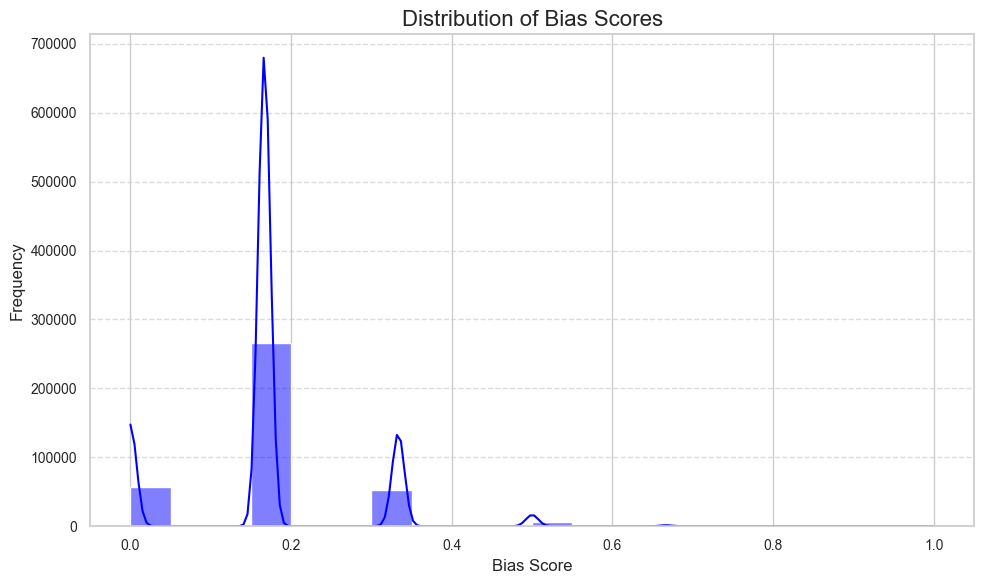

In [7]:
# Plotting bias distribution

# Setting Seaborn style
sns.set(style="whitegrid")

# Plotting histogram of 'bias'
plt.figure(figsize=(10, 6))
sns.histplot(headlines['bias'], bins=20, kde=True, color='blue')

# Styling the plot
plt.title('Distribution of Bias Scores', fontsize=16)
plt.xlabel('Bias Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Showing the plot
plt.tight_layout()
plt.show()

We see from our preliminary EDA that:
- Our DataFrame is fairly large, with a shape of (382139, 5). We will need to filter the dataset down a bit given the limitations of our project.
- The target variable 'bias' is quite imbalanced, as the majority of instances (265271) have a bias score of 0.166667.
- Because there are only 6 distinct bias scores, we will be treating the numerical bias scores as categorical. 

# Feature Engineering (for more EDA and Future Implementation) <a id='Feature_Engineering'></a>

We will continue our EDA by plotting various distributions, engineering more features, plotting interactions, and filtering the dataset to a manageable size. The purpose of this section is to show the breadth of engineering possibilities for future implementation; including all of these added features in modeling poses a significant challenge to the scope and time constraints on this project.

In [8]:
# Creating feature 'sentiment_polarity'- scale of -1 to 1

# Creating a sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Applying the sentiment analyzer to each headline and storing the compound score - this takes a while to run
headlines['sentiment_polarity'] = headlines['headline_no_site'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [9]:
# Getting distribution of sentiment_polarity
headlines['sentiment_polarity'].value_counts()

sentiment_polarity
 0.0000    127683
-0.2960      6871
 0.4019      5231
-0.4767      4682
-0.3182      4423
            ...  
 0.6075         1
-0.4690         1
 0.5991         1
 0.7854         1
 0.4388         1
Name: count, Length: 4977, dtype: int64

In [10]:
# Printing min and max values for sentiment polarity
print(headlines['sentiment_polarity'].min())
print(headlines['sentiment_polarity'].max())

-0.979
0.9682


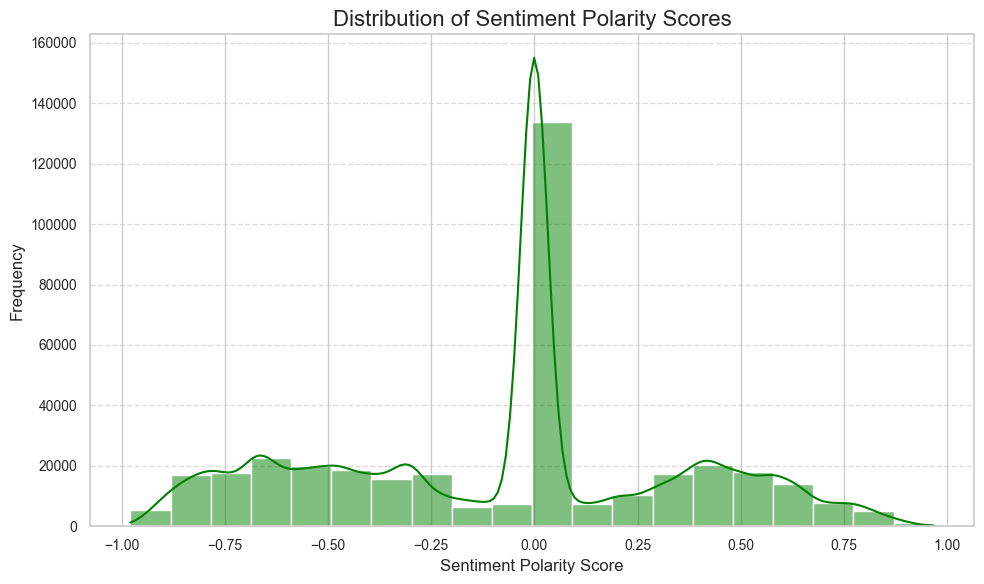

In [11]:
# Plotting dist of sentiment polarity

# Setting Seaborn style
sns.set(style="whitegrid")

# Plotting histogram of 'sentiment_polarity'
plt.figure(figsize=(10, 6))
sns.histplot(headlines['sentiment_polarity'], bins=20, kde=True, color='green')

# Styling the plot
plt.title('Distribution of Sentiment Polarity Scores', fontsize=16)
plt.xlabel('Sentiment Polarity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Showing the plot
plt.tight_layout()
plt.show()

In [12]:
# Engineering 'Day of the Week' and 'Month' Features
headlines['Day_of_Week'] = pd.to_datetime(headlines['time']).dt.day_name()
headlines['Month'] = pd.to_datetime(headlines['time']).dt.month

# Engineering 'Hour of Dat' feature
headlines['Hour_of_Day'] = pd.to_datetime(headlines['time']).dt.hour

# Converting 'time' column to datetime format
headlines['time'] = pd.to_datetime(headlines['time'], errors='coerce')

# Extracting the year and creating a new 'Publication Year' feature
headlines['Publication_Year'] = headlines['time'].dt.year

In [13]:
# Dropping time column
headlines = headlines.drop(columns=['time'])

In [14]:
# Creating word count feature
headlines['Word_Count'] = headlines['headline_no_site'].apply(lambda x: len(x.split()))

# Creating text length feature
headlines['Text_Length'] = headlines['headline_no_site'].apply(len)

In [15]:
# Inspecting new head
headlines.head()

,headline_no_site,site,country,bias,sentiment_polarity,Day_of_Week,Month,Hour_of_Day,Publication_Year,Word_Count,Text_Length
0,'Lady Bird' buzzes through young sexuality,iol.co.za,South Africa,0.000000,0.0000,Friday,2,8,2018,6,42
1,The shadowy urban POP super Starrah who loves ...,iol.co.za,South Africa,0.166667,0.8225,Wednesday,1,8,2018,10,57
2,Rihanna pens heartfelt tribute to her mom in b...,iol.co.za,South Africa,0.333333,0.5423,Wednesday,2,8,2018,10,58
3,Shock as woman accused of killing teen girlfri...,iol.co.za,South Africa,0.333333,-0.7184,Tuesday,2,8,2018,11,65
4,TOP STORY: Meet South Africa's new first lady ...,iol.co.za,South Africa,0.166667,0.3680,Thursday,2,8,2018,10,62


In [16]:
# Getting value counts for site
headlines['site'].value_counts()

site
dailymail.co.uk    8219
telegraph.co.uk    7596
abcnews.go.com     6305
indiatimes.com     6269
mirror.co.uk       6207
                   ... 
news.google.com       4
makeuseof.com         3
howtogeek.com         3
pcadvisor.co.uk       1
dailysun.co.za        1
Name: count, Length: 186, dtype: int64

In [17]:
# Setting a threshold for news sites with at least 5000 headlines
min_headlines_threshold = 5000
top_sites = headlines['site'].value_counts()
top_sites = top_sites[top_sites >= min_headlines_threshold].index

# Creating a new dataframe with only the sites with at least 5000 headlines
headlines_filtered = headlines[headlines['site'].isin(top_sites)].copy()

In [18]:
# Getting value counts for country
headlines_filtered['country'].value_counts()

country
UK       42593
USA      39050
India    36306
Name: count, dtype: int64

/var/folders/xl/6sfvtvk54y1982txcc62tyqw0000gn/T/ipykernel_3228/1489788177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='country', data=headlines_filtered, palette='viridis')


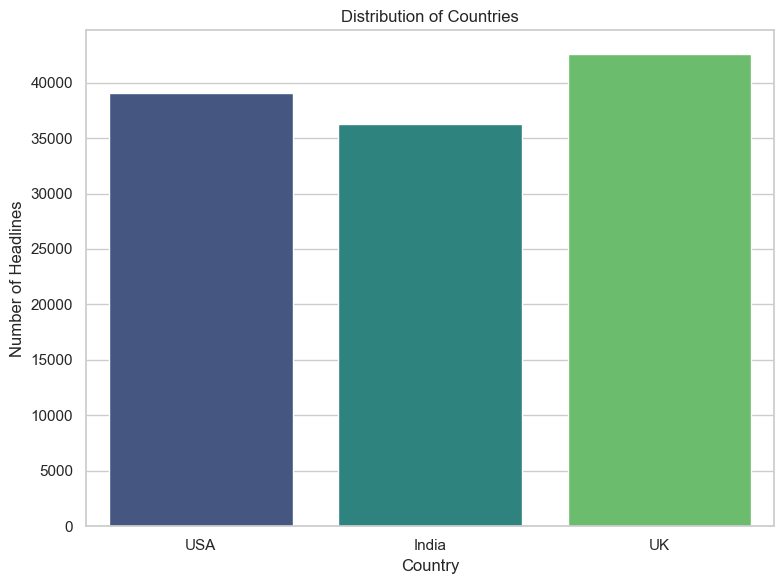

In [19]:
# Getting distribution of countries
plt.figure(figsize=(8, 6))
sns.countplot(x='country', data=headlines_filtered, palette='viridis')
plt.title('Distribution of Countries')
plt.xlabel('Country')
plt.ylabel('Number of Headlines')
plt.tight_layout()

# Showing the plot
plt.show()

In [20]:
# Filtering out all data for 'UK' and 'India' so that we stay in the US
headlines_filtered = headlines_filtered[headlines_filtered['country'].isin(['USA'])]

# Verify the changes
print(headlines_filtered['country'].value_counts())

country
USA    39050
Name: count, dtype: int64


In [21]:
# Getting shape of new DataFrame
headlines_filtered.shape

(39050, 11)

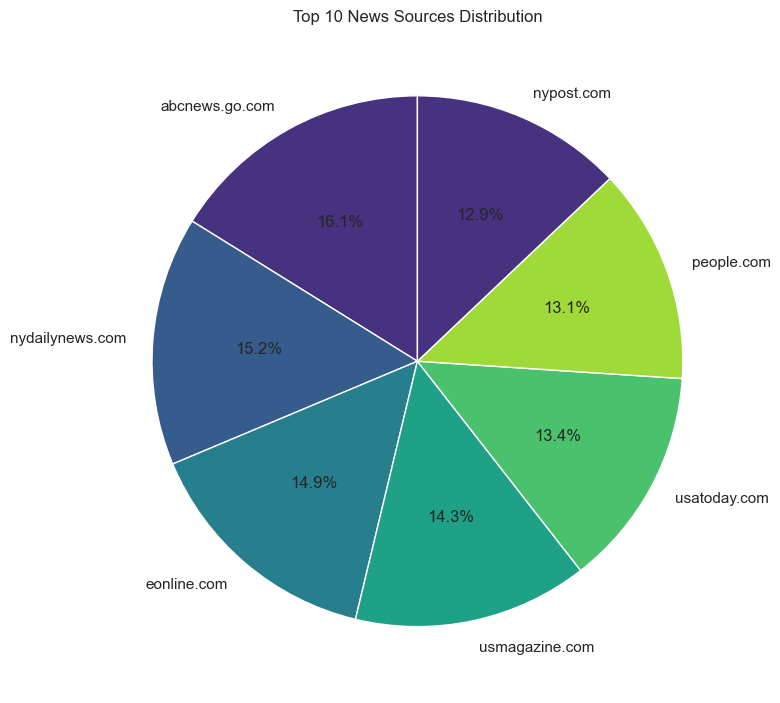

In [22]:
# Getting top 10 sites with most headlines
top_10_sites = headlines_filtered['site'].value_counts().nlargest(10)

# Creating a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_10_sites, labels=top_10_sites.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'), startangle=90)
plt.title('Top 10 News Sources Distribution')
plt.tight_layout()

# Showing the plot
plt.show()

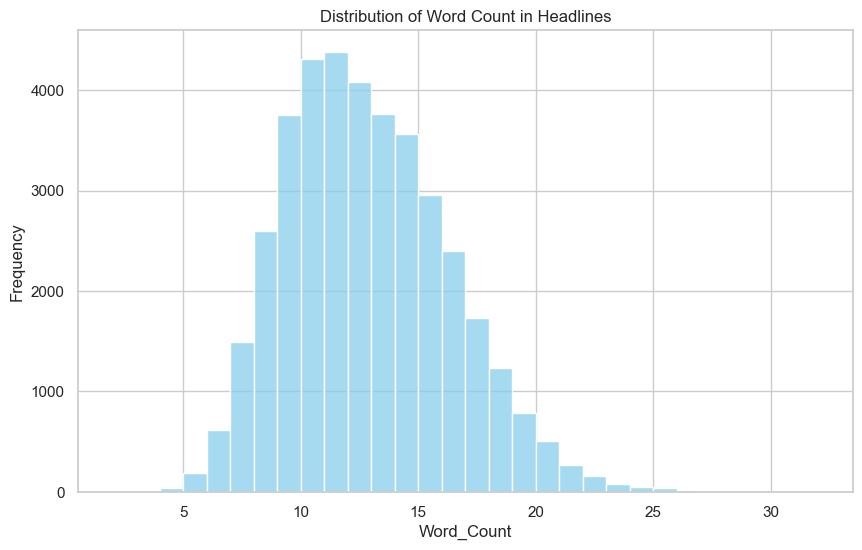

In [23]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(headlines_filtered['Word_Count'], bins=30, color='skyblue', kde=False)
plt.title('Distribution of Word Count in Headlines')
plt.xlabel('Word_Count')
plt.ylabel('Frequency')

# Show the plot
plt.show()

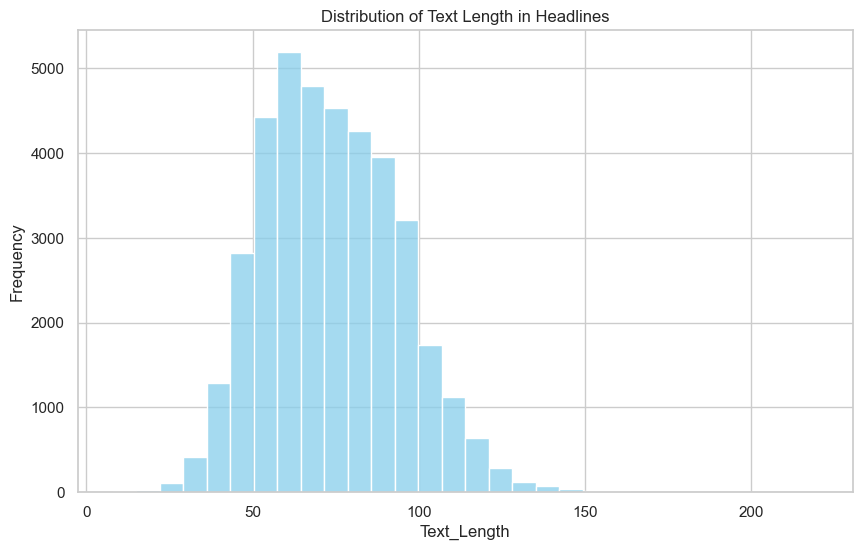

In [24]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(headlines_filtered['Text_Length'], bins=30, color='skyblue', kde=False)
plt.title('Distribution of Text Length in Headlines')
plt.xlabel('Text_Length')
plt.ylabel('Frequency')

# Show the plot
plt.show()

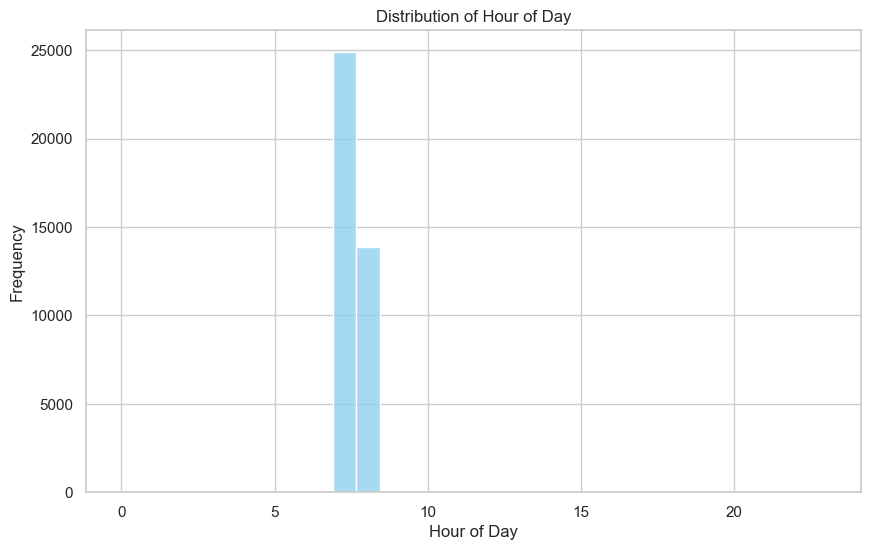

In [25]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(headlines_filtered['Hour_of_Day'], bins=30, color='skyblue', kde=False)
plt.title('Distribution of Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')

# Show the plot
plt.show()

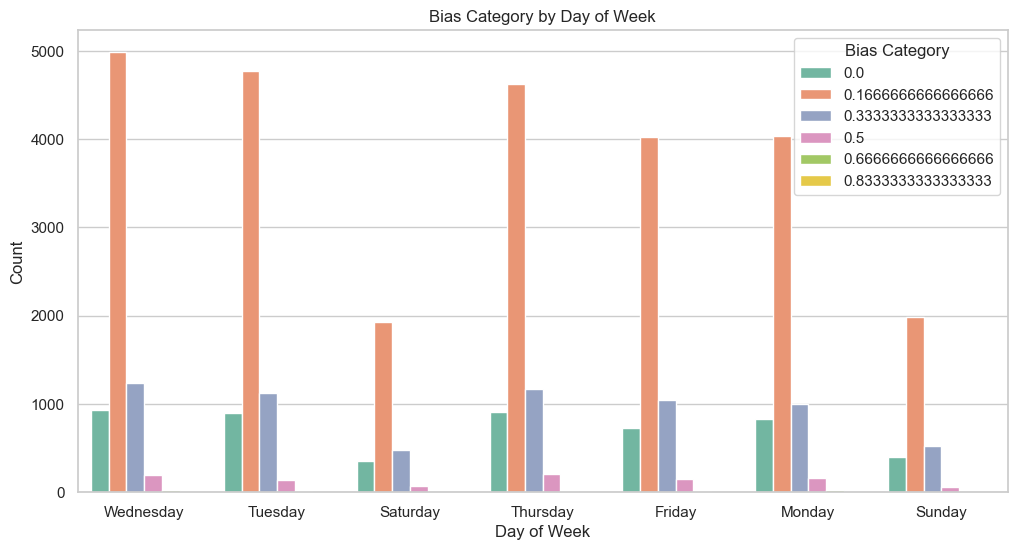

In [26]:
# Plotting Bias Category by Day of Week

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a count plot
plt.figure(figsize=(12, 6))
sns.countplot(data=headlines_filtered, x='Day_of_Week', hue='bias', palette='Set2')
plt.title('Bias Category by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.legend(title='Bias Category')
plt.show()

In [27]:
# Getting distribution of bias in headlines_filtered
headlines_filtered['bias'].value_counts()

bias
0.166667    26343
0.333333     6576
0.000000     5041
0.500000      982
0.666667      104
0.833333        4
Name: count, dtype: int64

In [28]:
# Setting values to drop
values_to_drop = [0.666667, 0.833333]

# Use boolean indexing to drop rows with specified values in 'bias' column
headlines_filtered = headlines_filtered[~headlines_filtered['bias'].isin(values_to_drop)]

In [29]:
# Defining conditions
conditions = [
    headlines_filtered['bias'].between(0.000000, 0.000000, inclusive='both'),
    headlines_filtered['bias'].between(0.1, 0.2, inclusive='both'),
    headlines_filtered['bias'].between(0.3, 0.5, inclusive='both'),
]

# Setting category labels
labels = ['No Bias', 'Low Bias', 'High Bias']

# Applying conditions
headlines_filtered['bias_category'] = np.select(conditions, labels, default=None)

In [30]:
# Getting unique bias category values
headlines_filtered['bias_category'].unique()

array(['High Bias', 'Low Bias', 'No Bias', None], dtype=object)

In [31]:
headlines_filtered['bias_category'].isnull().sum()

108

In [32]:
headlines_filtered = headlines_filtered.dropna()

In [33]:
headlines_filtered.isnull().sum()

headline_no_site      0
site                  0
country               0
bias                  0
sentiment_polarity    0
Day_of_Week           0
Month                 0
Hour_of_Day           0
Publication_Year      0
Word_Count            0
Text_Length           0
bias_category         0
dtype: int64

In [34]:
headlines_filtered['bias_category'].value_counts()

bias_category
Low Bias     26343
High Bias     7558
No Bias       5041
Name: count, dtype: int64

In [35]:
headlines_filtered.shape

(38942, 12)

In [36]:
# Dropping original bias column
headlines_filtered = headlines_filtered.drop(columns=['bias'])

/var/folders/xl/6sfvtvk54y1982txcc62tyqw0000gn/T/ipykernel_3228/1319201451.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=headlines_filtered, x='Publication_Year', y='bias_category', ci=None)


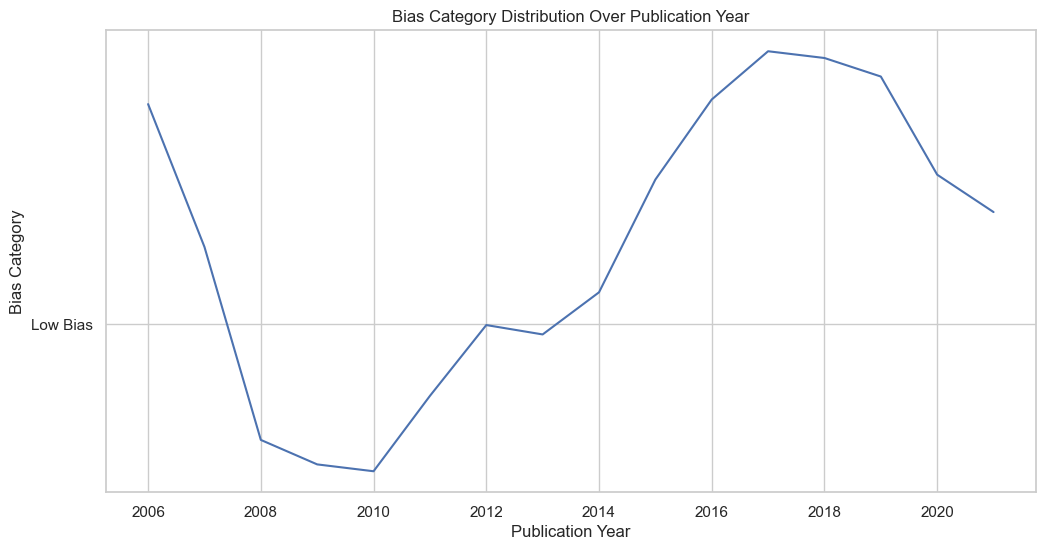

In [37]:
# Plotting the distribution of bias_category by Publication_Year

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=headlines_filtered, x='Publication_Year', y='bias_category', ci=None)
plt.title('Bias Category Distribution Over Publication Year')
plt.xlabel('Publication Year')
plt.ylabel('Bias Category')
plt.show()

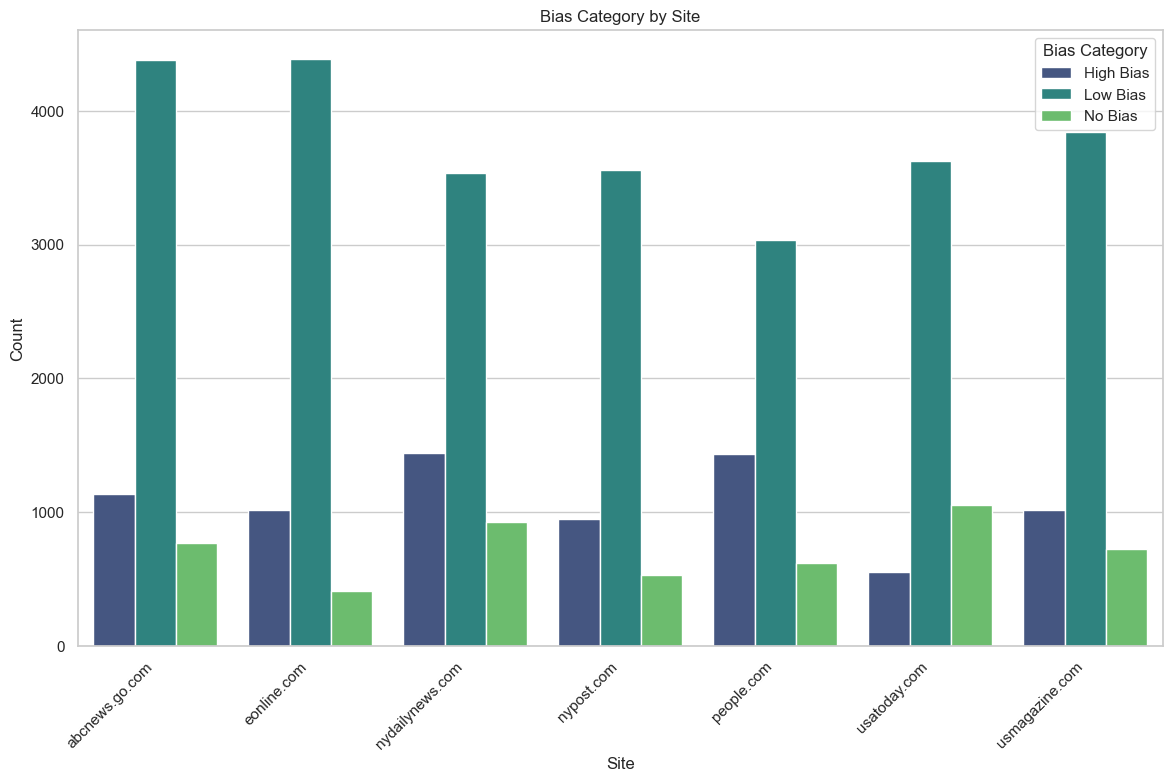

In [38]:
# Plotting Bias Category by Site

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a count plot
plt.figure(figsize=(14, 8))
sns.countplot(data=headlines_filtered, x='site', hue='bias_category', palette='viridis')
plt.title('Bias Category by Site')
plt.xlabel('Site')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend(title='Bias Category')
plt.show()

/var/folders/xl/6sfvtvk54y1982txcc62tyqw0000gn/T/ipykernel_3228/1690570023.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violin = sns.violinplot(x='bias_category', y='sentiment_polarity', data=headlines_filtered, inner='quartile', palette='viridis')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


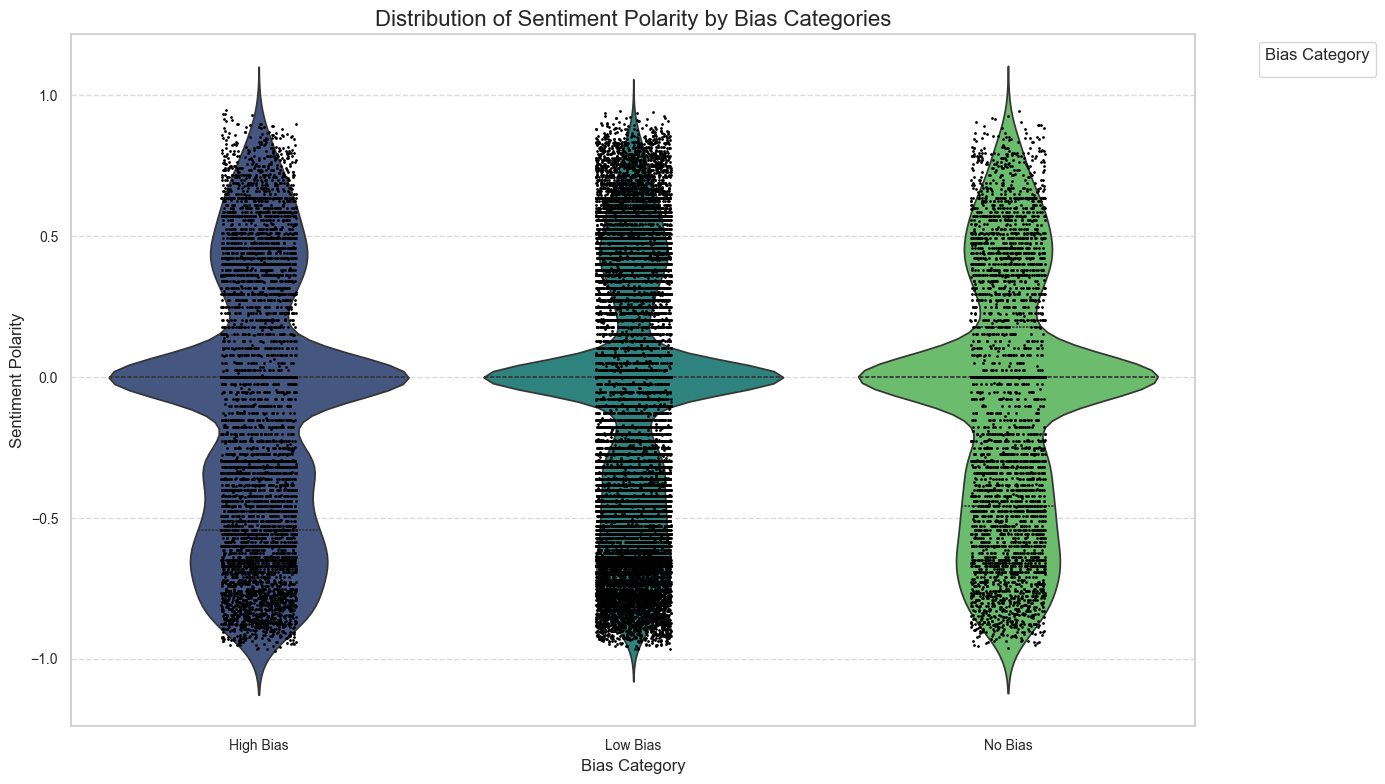

In [39]:
# Plotting the Distribution of Sentiment Polarity by Bias Categories

# Setting a Seaborn style
sns.set(style="whitegrid")

# Setting fig size, creating plot of feature interaction
plt.figure(figsize=(14, 8))

# Creating a violin plot with strip plot overlay
violin = sns.violinplot(x='bias_category', y='sentiment_polarity', data=headlines_filtered, inner='quartile', palette='viridis')
strip = sns.stripplot(x='bias_category', y='sentiment_polarity', data=headlines_filtered, color='black', size=2, jitter=True)

# Styling the plot
plt.title('Distribution of Sentiment Polarity by Bias Categories', fontsize=16)
plt.xlabel('Bias Category', fontsize=12)
plt.ylabel('Sentiment Polarity', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding a legend
plt.legend(title='Bias Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Showing the plot
plt.tight_layout()
plt.show()


In [40]:
# Renaming the 'headlines_no_site' column to 'headlines'
headlines_filtered.rename(columns={'headline_no_site': 'headlines'}, inplace=True)

headlines_filtered['headlines'].head()

9207           Mother and Daughter Reunite After 82 Years
9208    Hayden Panettiere 'Happy' to Stand Up for Wome...
9209    Woman Gets Trendy Tattoo to 'Caution' People S...
9210    Timeline of Alleged Abduction and Slaying of 1...
9211    Unabomber Ted Kaczynski's Brother, Sister in L...
Name: headlines, dtype: object

The main takeaway from this section is that we have an imbalanced dataset, skewing towards the Low Bias category. Since classification models don't assume a normal distribution of the target, we won't worry too much about that. We will simply see how the models perform and attempt to explain their behavior.

# Preprocessing<a id='Preprocessing'></a>

To sufficiently prepare our modeling, we must properly preprocess our text data. We begin by importing the following:

In [41]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
import gensim
import gensim.downloader
from gensim.utils import simple_preprocess

We proceed with **tokenizing the headline text:** The `word_tokenize` function is applied to each headline to split it into a list of words or tokens, and the result is stored in the 'tokenized_text' column.

We then **remove non-alphabetic characters, handling empty strings, and extra spaces:** The 'cleaned_text' column is created by applying a lambda function to each tokenized text. This function removes non-alphabetic characters, handles empty strings, and strips extra spaces from each token.

Next, we **converting to lowercase:** Another lambda function is applied to convert all words in the 'cleaned_text' column to lowercase, ensuring uniformity in text case.

Finally, we proceed with **Lemmatization:** Lemmatization reduces words to their base or root form, aiding in text normalization. The 'lemmatized_text' column is created by applying a lambda function that lemmatizes each word in the 'cleaned_text' column using the WordNet lemmatizer.  Note that lemmatization can take a bit of time to run.

In [42]:
# Tokenize, Clean, and Lemmatize Text

# Tokenizing the headline text
headlines_filtered['tokenized_text'] = headlines_filtered['headlines'].apply(word_tokenize)

# Removing non-alphabetic characters, handle empty strings, and extra spaces
headlines_filtered['cleaned_text'] = headlines_filtered['tokenized_text'].apply(lambda tokens: [re.sub(r'[^a-zA-Z0-9]', '', token).strip() for token in tokens if re.sub(r'[^a-zA-Z0-9]', '', token).strip()])

# Converting to lowercase
headlines_filtered['cleaned_text'] = headlines_filtered['cleaned_text'].apply(lambda tokens: [token.lower() for token in tokens])

# Lemmatization - this takes a minute or two to run
lemmatizer = WordNetLemmatizer()
headlines_filtered['lemmatized_text'] = headlines_filtered['cleaned_text'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

Let's make a copy of `headlines_filtered`, save it as `lemmatized_df` and clean it up a bit.

In [43]:
# Storing a copy of headlines_filtered_encoded as lemmatized_df
lemmatized_df = headlines_filtered.copy()

In [44]:
# Dropping the 'headlines' column from lemmatized_df
lemmatized_df.drop('headlines', axis=1, inplace=True)

# Displaying the first row of lemmatized_df after dropping the column
lemmatized_df.head(1)

,site,country,sentiment_polarity,Day_of_Week,Month,Hour_of_Day,Publication_Year,Word_Count,Text_Length,bias_category,tokenized_text,cleaned_text,lemmatized_text
9207,abcnews.go.com,USA,0.0,Wednesday,2,8,2016,7,42,High Bias,"[Mother, and, Daughter, Reunite, After, 82, Ye...","[mother, and, daughter, reunite, after, 82, ye...","[mother, and, daughter, reunite, after, 82, year]"



We'll now proceed to eliminate stopwords, which don't hold much meaning.
First, we **get stop words:** The `stopwords.words('english')` function retrieves a set of English stop words from NLTK's corpus and is stored in the 'stop_words' variable.

Then, we can **create no stopwords feature:** A new column 'lemmatized_text_no_stopwords' is created in the 'lemmatized_df' DataFrame. It is obtained by applying a lambda function to each list of lemmatized tokens in the 'lemmatized_text' column. This function filters out tokens that are stop words, effectively removing them from the lemmatized text.

In [45]:
# Getting stop words
stop_words = set(stopwords.words('english'))

# Creating no stopwords feature, removing stop words from the lemmatized_text column
lemmatized_df['lemmatized_text_no_stopwords'] = lemmatized_df['lemmatized_text'].apply(lambda tokens: [token for token in tokens if token not in stop_words])

In [46]:
# Inspecting head of lemmatized_text_no_stopwords feature
lemmatized_df['lemmatized_text_no_stopwords'].head()

9207                [mother, daughter, reunite, 82, year]
9208    [hayden, panettiere, happy, stand, woman, post...
9209    [woman, get, trendy, tattoo, caution, people, ...
9210    [timeline, alleged, abduction, slaying, 13, ye...
9211    [unabomber, ted, kaczynski, brother, sister, l...
Name: lemmatized_text_no_stopwords, dtype: object

Let's make a copy of our working dataframe, drop some columns, and inspect:

In [47]:
# Storing a copy of lemmatized_df as df_to_vectorize
df_to_vectorize = lemmatized_df.copy()

In [48]:
# Setting list of columns to drop
columns_to_drop = ['tokenized_text', 'cleaned_text', 'lemmatized_text']

# Dropping the specified columns
df_to_vectorize.drop(columns=columns_to_drop, inplace=True)

In [49]:
# Inspecting head 
df_to_vectorize.head(1)

,site,country,sentiment_polarity,Day_of_Week,Month,Hour_of_Day,Publication_Year,Word_Count,Text_Length,bias_category,lemmatized_text_no_stopwords
9207,abcnews.go.com,USA,0.0,Wednesday,2,8,2016,7,42,High Bias,"[mother, daughter, reunite, 82, year]"


The following few code blocks were adapted from a [project](https://github.com/melissaleeyvr/Predicting-Media-Bias-in-News-Articles) by Melissa Lee, available on GitHub.

Before vectorizing, or representing our text numerically, it would be extremely helpful if we could download a pretrained model to help us capture semantic relationships between common news words. 

To do this, we:

**Print available models:** The `gensim.downloader.info()` function provides information about available models in `Gensim`'s `gensim-data` module. The list of model names is obtained using ['models'].keys(), and it is printed.

**Download a pre-trained word embedding model:** The `gensim.downloader.load('fasttext-wiki-news-subwords-300')` function downloads a pre-trained word embedding model named 'fasttext-wiki-news-subwords-300' from gensim's model repository. The downloaded model is assigned to the variable 'model'. Note that downloading the model may take some time.

In [50]:
# Printing available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [51]:
# Downloading a pre-trained word embedding model and assigning it to 'model'- this will take a while! 
model = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [52]:
# Defining function
def text2vec(text):
        # Assigning the input list of tokenized words to the variable 'tokenized'
    tokenized = text
        # Initializing an empty list to store word embeddings
    word_embeddings = [np.zeros(300)]
        # Iterating over each word in the tokenized list
    for word in tokenized:
        if word in model:  # Checking if the word is present in the pre-trained word embedding model
            vector = model[word]  # If present, retrieving the word embedding vector for the word
        else:
            vector = np.zeros(300) # If not present, assigning a zero vector

        word_embeddings.append(vector)  # Appending the word embedding vector to the list
    # Converting the list of word embeddings to a NumPy array and calculating the mean along the axis 0
    text_embedding = np.stack(word_embeddings).mean(axis=0) 
    # Returning the average word embedding for the entire text
    return text_embedding

In [53]:
# Applying the function over the lemmatized text column and assigning the results to new column
df_to_vectorize['headline_vectors'] = df_to_vectorize['lemmatized_text_no_stopwords'].apply(lambda x: text2vec(x))

In [54]:
# Inspecting headline vectors
df_to_vectorize['headline_vectors'].head()

9207    [-0.010114432700599233, 0.02315941619842003, 0...
9208    [-0.018402375280857086, -0.012355675251455978,...
9209    [-0.012091000284999608, -0.0066915501840412615...
9210    [-0.005805909133050591, 0.009975600615143776, ...
9211    [-0.01995395952835679, -0.022855930007062854, ...
Name: headline_vectors, dtype: object

In [55]:
# Making copy of df_to_vectorize
final_df = df_to_vectorize.copy()

In [56]:
# Dropping the 'lemmatized_text_no_stopwords' column
final_df = final_df.drop('lemmatized_text_no_stopwords', axis=1)

In [57]:
# Checking headlines vectors of first row in new filtered dataset
final_df['headline_vectors'][9207]

array([-1.01144327e-02,  2.31594162e-02,  3.38478331e-02, -2.61983400e-03,
        3.62601659e-02, -1.06493332e-02, -2.57916904e-04, -6.91277822e-02,
        3.44547993e-02, -3.27153669e-02,  2.43166648e-03,  2.58481659e-02,
        1.29131333e-02,  2.27498331e-02, -1.53669997e-02,  1.92172999e-02,
        2.11366670e-02, -2.11813335e-02,  1.02198500e-02,  3.86651834e-02,
       -6.10258337e-03, -4.23399964e-03, -5.46613497e-02,  8.27141653e-02,
        4.34007682e-02, -6.78025023e-03, -3.30020006e-03,  5.34819920e-03,
        2.84163666e-02,  1.97139827e-02,  7.35648190e-03,  1.29883364e-03,
       -2.31769999e-02, -4.24127669e-02, -1.95416656e-02, -4.42306713e-03,
       -3.61550009e-02, -4.07092326e-02,  1.79235004e-02, -1.36735667e-02,
       -6.36928327e-03, -4.02288832e-02,  1.82416600e-03, -3.50693002e-02,
        2.19708999e-02,  7.66333348e-02, -1.09447500e-02, -8.70424982e-03,
       -4.63549979e-03,  1.90033337e-02,  2.40958499e-02, -1.86153332e-02,
        6.97495028e-03,  

In [58]:
# Checking final_df for null values
final_df.isnull().sum()

site                  0
country               0
sentiment_polarity    0
Day_of_Week           0
Month                 0
Hour_of_Day           0
Publication_Year      0
Word_Count            0
Text_Length           0
bias_category         0
headline_vectors      0
dtype: int64

Our text data is now vectorized and ready for a train-test split!

# Train Test Split<a id='Train_Test_Split'></a>

We begin by importing `train_test_split`:

In [59]:
from sklearn.model_selection import train_test_split

Now, we set our X and y variables to 'headline_vectors' and 'bias_category', respectively. Then, we split the data using `train_test_split` function, specifying a test size of 0.2 and a random state of 42. Then, we print the shape of each variable:

In [60]:
# Setting X and y variables
X = final_df[['headline_vectors']]
y = final_df['bias_category']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Printing the shapes of each variable
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (31153, 1)
y_train shape: (31153,)
X_test shape: (7789, 1)
y_test shape: (7789,)


In [61]:
# Ensuring there are no NaN values in y_train
y_train.unique()

array(['Low Bias', 'No Bias', 'High Bias'], dtype=object)

In [62]:
# Ensuring there are no NaN values in y_test
y_test.unique()

array(['High Bias', 'Low Bias', 'No Bias'], dtype=object)

Most machine learning models in libraries expect input features to be in the form of arrays, so we will have to convert our X_train and X_test variables to arrays. To do this, we: **extract the vector** and employ the `.tolist()` function, which converts the column of vectors into a Python list. This step is necessary because the subsequent conversion to a NumPy array (`np.array()`) expects an iterable.

In [63]:
# Converting X_train vectors to arrays
X_train_array = np.array(X_train['headline_vectors'].tolist())

# Converting X_test vectors to arrays
X_test_array = np.array(X_test['headline_vectors'].tolist())                           

In [64]:
# Inspecting X_train_array
X_train_array

array([[ 0.0118112 , -0.02826263,  0.03267959, ...,  0.00386307,
        -0.00758984, -0.00887941],
       [-0.01827431, -0.01129786,  0.05658613, ...,  0.02443756,
         0.01415028, -0.00603041],
       [-0.02869413, -0.00154161,  0.0110755 , ..., -0.01070486,
         0.03394732, -0.02429571],
       ...,
       [-0.0139151 , -0.01404694, -0.01344482, ..., -0.00026128,
        -0.00103142,  0.01009311],
       [ 0.01821074,  0.00642931,  0.0055661 , ...,  0.00886271,
         0.00948076, -0.01122147],
       [-0.005537  , -0.0081595 , -0.0094773 , ...,  0.01574317,
         0.02318462, -0.02449353]])

In [65]:
# Inspecting X_test_array
X_test_array

array([[-0.00622362,  0.00438962,  0.01905515, ...,  0.01767301,
         0.00946958, -0.00454697],
       [-0.00619883,  0.00523364,  0.01358382, ...,  0.01534192,
         0.02205315,  0.00835001],
       [ 0.00727306,  0.01166421,  0.00144094, ...,  0.0063027 ,
         0.00755804, -0.00780539],
       ...,
       [-0.02757343, -0.05089681, -0.01921928, ...,  0.02215261,
        -0.01848897, -0.00681179],
       [-0.00685749, -0.00837797,  0.00985022, ...,  0.01316061,
        -0.02753942, -0.00887434],
       [-0.00728046, -0.01582115,  0.00636818, ..., -0.00456625,
         0.0232201 ,  0.0174868 ]])

Before we begin modeling, let's discuss the evaluation metric we will focus on for evaluation:

## Evaluation Metric: Weighted Average F1<a id='Evaluation Metrics'></a>
We will be focusing on Weighted Average F1 score as an evaluation metric across all models.

#### Context for Our Stakeholder 

#### False Positives
- **Cost**: A false positive occurs when a headline is *incorrectly classified as having a bias that it does not possess.* For PBS, false positives can lead to inaccurate categorization for otherwise passable headlines, which we want to avoid.
- **Implication for our Stakeholder**: It is crucial to minimize false positives to maintain the credibility of PBS's ability to classify bias. Readers relying on these classifications should trust that the information accurately reflects the intended bias.

#### False Negatives
- **Cost**: A false negative occurs when a biased headline is *incorrectly classified as unbiased.* This might result in overlooking misleading information and passing off headlines that aren't fit to be published.
- **Implication for our Stakeholder**: Striking the right balance is essential to ensure readers are alerted to potential bias when it exists.

#### The Role of Weighted F1 Score
The Weighted Average F1 score is an appropriate evaluation metric for predicting headline bias categories for PBS due to its ability to balance precision and recall while accounting for class imbalance. In the context of classifying bias categories, it ensures that the model's performance is assessed considering *both false positives and false negatives,* providing a comprehensive measure of predictive accuracy.

# Simple Models

We begin our modeling process by running a few simple models as a reference point for more complex models.

Let's begin our by importing all necessary libraries, modules and packages:

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Logistic Regression<a id='Logistic Regression'></a>

Logistic Regression is a good jumping off point due to its simplicity, interpretability, and efficiency in handling binary or multiclass classification tasks. To start, we initialize a logistic regression model (`logreg_model`), and the `max_iter` parameter is set to 1000 to ensure convergence during the training process. We then fit the model to the training variables, make predictions on the test variable, and calculate the weighted average precision:

In [67]:
# Creating a logistic regression model
logreg_model = LogisticRegression(max_iter=1000)

# Fitting the model to the training data
logreg_model.fit(X_train_array, y_train)

LogisticRegression(max_iter=1000)

In [68]:
# Making predictions on the test set
logreg_y_pred = logreg_model.predict(X_test_array)

In [69]:
# Generating confusion matrix
logreg_cm = confusion_matrix(y_test, logreg_y_pred)
logreg_cm

array([[ 282, 1205,    0],
       [ 152, 5092,    0],
       [  23, 1034,    1]])

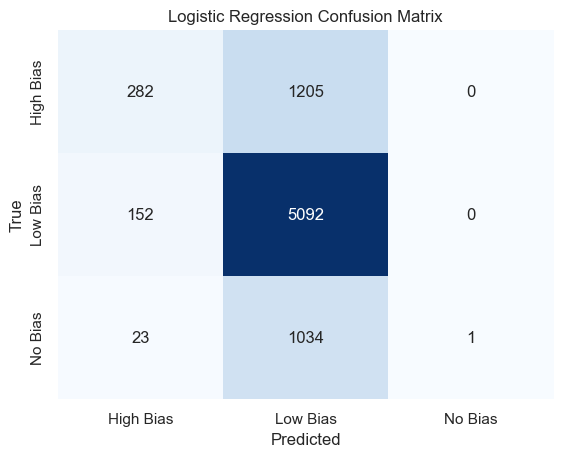

In [70]:
# Display the confusion matrix using a heatmap
sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=logreg_model.classes_, yticklabels=logreg_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [71]:
# Generate classification report
logreg_report = classification_report(y_test, logreg_y_pred)

# Print the classification report
print("Classification Report:\n", logreg_report)

Classification Report:
               precision    recall  f1-score   support

   High Bias       0.62      0.19      0.29      1487
    Low Bias       0.69      0.97      0.81      5244
     No Bias       1.00      0.00      0.00      1058

    accuracy                           0.69      7789
   macro avg       0.77      0.39      0.37      7789
weighted avg       0.72      0.69      0.60      7789



The model performs well in classifying "Low Bias" with high precision (0.69) and recall (0.97),which is to be expected, as there are far more instances of Low Bias than No or High.
We see the model struggles with "High Bias," showing lower precision (0.62) and recall (0.19). The 
"No Bias" category has perfect precision but lacks any recall. So, the model correctly identifies instances belonging to the "No Bias" category when it predicts it, but it might be missing a significant number of actual "No Bias" instances, showing an inability to generalize to new data.

**LogReg Weighted Average F1 score:** 60%.

A score 0.60 indicates a relatively good overall performance of the Logistic Regression model, though the overall imbalance in the model is suspect.

## Random Forest<a id='Random Forest'></a>

Random Forest is an ensemble learning method that constructs a multitude of decision trees during training and outputs the mode, where the class that appears most frequently across the trees is selected as the overall prediction. By combining predictions from multiple trees, Random Forest enhances accuracy and generalization while mitigating overfitting. For this reason, we think RF might be a good next step. Let's see if we see improvements.

We initialize a RF model, set n_estimators to the specified `num_trees`, fit the model to our training data, make predictions:

In [72]:
# Specify the desired number of trees
num_trees = 50

# Create an instance of RandomForestClassifier with the specified number of trees
rf_model = RandomForestClassifier(n_estimators=num_trees, random_state=42)

# Train the model on the training data
rf_model.fit(X_train_array, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [73]:
# Make predictions on the test set
rf_y_pred = rf_model.predict(X_test_array)

In [74]:
# Generate classification report
rf_report = classification_report(y_test, rf_y_pred)

# Print the classification report
print("Classification Report:\n", rf_report)

Classification Report:
               precision    recall  f1-score   support

   High Bias       0.59      0.09      0.16      1487
    Low Bias       0.68      0.98      0.81      5244
     No Bias       0.36      0.00      0.01      1058

    accuracy                           0.68      7789
   macro avg       0.54      0.36      0.33      7789
weighted avg       0.62      0.68      0.57      7789



In [75]:
# Get unique classes from y_test
unique_classes = np.unique(y_test)

# Generate confusion matrix
rf_cm = confusion_matrix(y_test, rf_y_pred)
rf_cm

array([[ 140, 1347,    0],
       [  87, 5150,    7],
       [  11, 1043,    4]])

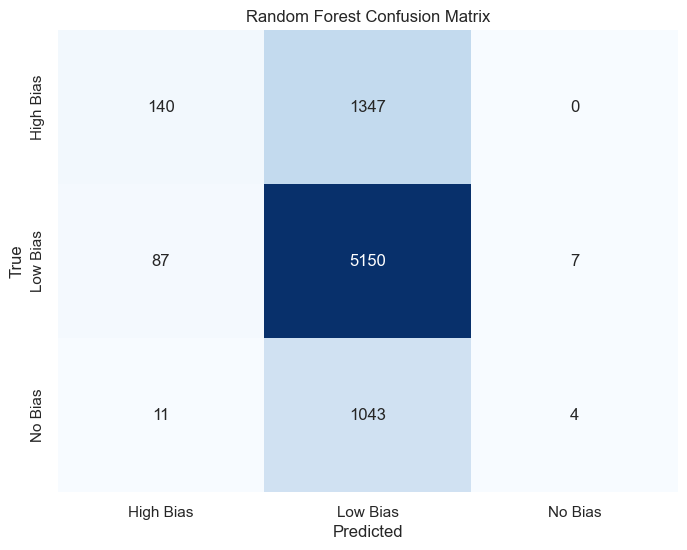

In [76]:
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()


We see that the RF model demonstrates solid performance in identifying headlines with "Low Bias," (again to be expected) achieving a high precision of 0.68 and high recall of 0.98, suggesting its effectiveness in correctly classifying low bias headlines. Again, the model struggles with headlines labeled as "High Bias" and "No Bias," indicating a higher rate of false positives in these categories.

**RF Weighted Average F1 score:** 57%, indicating a slightly poorer performance than our LogReg model by about 3%.

# Support Vector Machine<a id='Support Vector Machine'></a>

Support Vector Machines (SVM) classify data points by finding the hyperplane that maximally separates different classes in the feature space, aiming to achieve the best margin between them. SVM can be a powerful next step; let's see if this is the case. We initialize, fit/train, make predictions, and outut scores and confusion matrices:

In [77]:
# Creating an instance of Support Vector Machine (SVM) classifier
svm_model = SVC(random_state=42)

# Training the model on the training data
svm_model.fit(X_train_array, y_train)

# Making predictions on the test data
svm_y_pred = svm_model.predict(X_test_array)

In [78]:
# Generating classification report
svm_report = classification_report(y_test, svm_y_pred)

# Printing the classification report
print("Classification Report:\n", svm_report)

Classification Report:
               precision    recall  f1-score   support

   High Bias       0.73      0.18      0.29      1487
    Low Bias       0.70      0.98      0.81      5244
     No Bias       0.00      0.00      0.00      1058

    accuracy                           0.70      7789
   macro avg       0.48      0.39      0.37      7789
weighted avg       0.61      0.70      0.60      7789



/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
# Get unique classes from y_test
unique_classes = np.unique(y_test)

# Generate confusion matrix
svm_cm = confusion_matrix(y_test, svm_y_pred)
svm_cm

array([[ 269, 1218,    0],
       [  85, 5159,    0],
       [  13, 1045,    0]])

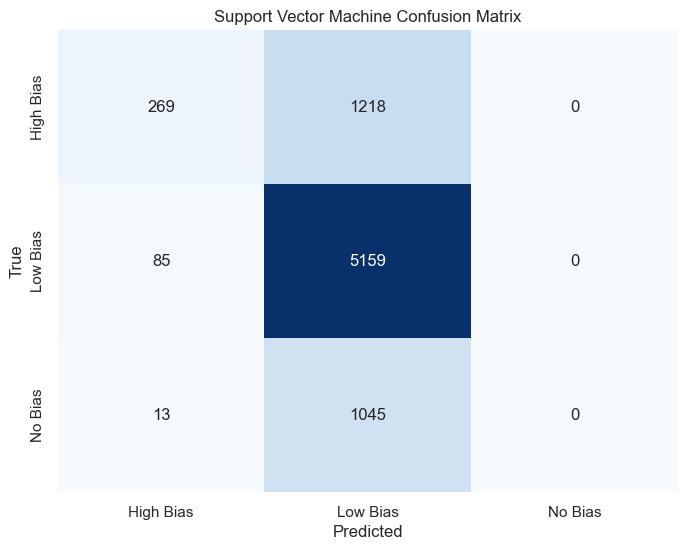

In [80]:
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Support Vector Machine Confusion Matrix')
plt.show()

Our SVM results show that for the "High Bias" category, the SVM model predicted 269 headlines correctly, 1218 headlines incorrectly as "Low Bias," and none correctly as "No Bias."
For the "Low Bias" category, the model predicted 5159 headlines correctly, 85 headlines incorrectly as "High Bias," and none correctly as "No Bias."
For the "No Bias" category, the model predicted none correctly for any category.

**SVM Weighted Average F1 score:** 60%, the same as our LogReg model. Not terrible! 

All our simple model results suggest that our class imbalance influences models greatly. Let's see if implementing more complex models will show more balanced behavior and yeild higher WAF1 scores.

# Complex Models

## Neural Networks<a id='Neural Networks'></a>

Neural networks are computational models inspired by the structure and function of the human brain, composed of interconnected nodes organized in layers. They excel in learning complex patterns and relationships from data, making them powerful for classification tasks like ours.

We begin by importing all necessary libraries, modules and packages:

In [81]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

2023-12-01 12:49:42.760917: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


These preprocessing steps are necessary when preparing categorical target variables for our neural networks: 

- Create and instance of `LabelEncoder:`, to convert class labels (strings or integers) into numerical format.
- Store encoded versions of target variables as `y_train_encoded` and `y_test_encoded` The `fit_transform` method converts categorical labels into t/f values.

- One-hot encode the above variables `to_categorical:`, which converts the numerical labels into binary vectors, where each element represents the presence or absence of a class.

- Set `class_labels:` to better interpret model outputs and decoding predictions back into their original class labels.

In [82]:
# Creating an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encoding y_test and y_train
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encoding y_train_encoded and y_test_encoded
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

# Setting class labels for later model output interpretation
class_labels = np.unique(y_train_encoded)

In [83]:
# Computing class weights for use in neural network models
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train_encoded)
class_weight_dict = dict(enumerate(class_weights))

We will now run a series of neural networks: a simple nn, nn with dropout rate, nn with L2 regularization, nn with batch normalization, and a multilayer perceptron with batch normalization. We will then evaluate which model performs the best.

### Baseline Neural Network 

First, a simple neural network architecture with 2 dense layers. Further explanation of the code below:

In [84]:
# Defining the neural network model with a baseline architecture of 2 layers

# Initialing a sequential model, which is a linear stack of layers
nn_model = Sequential()
# Adding first hidden layer with 64 neurons, input dimension determined by the number of features in the 
# training data (X_train_array), and ReLU activation function, which enables positive input 
#and filters negatives
nn_model.add(Dense(64, input_dim=X_train_array.shape[1], activation='relu'))
# Adding second hidden layer with 32 neurons and ReLU activation function
nn_model.add(Dense(32, activation='relu'))
# Adding the output layer with the number of neurons equal to the number of unique classes in the target variable. 
# Using softmax activation for multi-class classification, which converts model output into probabilities
nn_model.add(Dense(len(class_labels), activation='softmax'))

# Compiles the model, specifying the Adam optimizer (an adaptive optimization algorithm for training), 
#categorical crossentropy as the loss function
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model, running for 10 epochs with a batch size of 32, setting validation split of 20% and 
#specified previously calculated class weights 
nn_model.fit(X_train_array, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

Epoch 1/10
779/779 [==============================] - 3s 3ms/step - loss: 1.0234 - accuracy: 0.4007 - val_loss: 0.9383 - val_accuracy: 0.5651
Epoch 2/10
779/779 [==============================] - 2s 2ms/step - loss: 0.9634 - accuracy: 0.4579 - val_loss: 1.0363 - val_accuracy: 0.4107
Epoch 3/10
779/779 [==============================] - 2s 2ms/step - loss: 0.9395 - accuracy: 0.4752 - val_loss: 0.9655 - val_accuracy: 0.4970
Epoch 4/10
779/779 [==============================] - 2s 2ms/step - loss: 0.9195 - accuracy: 0.4904 - val_loss: 1.0185 - val_accuracy: 0.4348
Epoch 5/10
779/779 [==============================] - 2s 2ms/step - loss: 0.9044 - accuracy: 0.4961 - val_loss: 1.0300 - val_accuracy: 0.4473
Epoch 6/10
779/779 [==============================] - 1s 2ms/step - loss: 0.8898 - accuracy: 0.5052 - val_loss: 0.9840 - val_accuracy: 0.4500
Epoch 7/10
779/779 [==============================] - 1s 2ms/step - loss: 0.8750 - accuracy: 0.5118 - val_loss: 0.9562 - val_accuracy: 0.5047
Epoch 

In [85]:
# Making predictions on the test data
nn_model_y_pred_one_hot = nn_model.predict(X_test_array)

# Converting the predicted probabilities to class labels
nn_model_y_pred_classes = np.argmax(nn_model_y_pred_one_hot, axis=1)

244/244 [==============================] - 0s 1ms/step


In [86]:
# Printing classification report for baseline neural network
print(classification_report(y_test_encoded, nn_model_y_pred_classes, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

   High Bias       0.36      0.73      0.48      1487
    Low Bias       0.80      0.44      0.57      5244
     No Bias       0.26      0.45      0.33      1058

    accuracy                           0.50      7789
   macro avg       0.47      0.54      0.46      7789
weighted avg       0.64      0.50      0.52      7789



**Simple Neural Network Weighted Average F1 score:** 48%

### Neural Network with Dropout Rate

Dropout is a regularization technique that randomly sets a fraction (0.5) of input units to zero during training. This helps prevent overfitting by reducing reliance on specific neurons.

We'll add dropout rates to our original architecture:

In [87]:
# Defining the neural network model
nn_model_2 = Sequential()
nn_model_2.add(Dense(64, input_dim=X_train_array.shape[1], activation='relu'))
nn_model_2.add(Dropout(0.5))  # Adding dropout rate of 0.5
nn_model_2.add(Dense(32, activation='relu'))
nn_model_2.add(Dropout(0.5))  # Adding dropout rate of 0.5
nn_model_2.add(Dense(len(class_labels), activation='softmax'))

# Compile the model with class weights
nn_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
nn_model_2.fit(X_train_array, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

Epoch 1/10
779/779 [==============================] - 2s 2ms/step - loss: 1.0737 - accuracy: 0.4014 - val_loss: 1.0361 - val_accuracy: 0.3877
Epoch 2/10
779/779 [==============================] - 2s 3ms/step - loss: 1.0228 - accuracy: 0.3843 - val_loss: 1.0082 - val_accuracy: 0.4152
Epoch 3/10
779/779 [==============================] - 2s 2ms/step - loss: 0.9971 - accuracy: 0.4059 - val_loss: 1.0396 - val_accuracy: 0.3696
Epoch 4/10
779/779 [==============================] - 2s 2ms/step - loss: 0.9814 - accuracy: 0.4289 - val_loss: 1.0091 - val_accuracy: 0.4049
Epoch 5/10
779/779 [==============================] - 1s 2ms/step - loss: 0.9727 - accuracy: 0.4459 - val_loss: 0.9815 - val_accuracy: 0.4580
Epoch 6/10
779/779 [==============================] - 2s 2ms/step - loss: 0.9628 - accuracy: 0.4388 - val_loss: 0.9749 - val_accuracy: 0.4673
Epoch 7/10
779/779 [==============================] - 1s 2ms/step - loss: 0.9511 - accuracy: 0.4439 - val_loss: 1.0038 - val_accuracy: 0.4165
Epoch 

In [88]:
# Make predictions on the test data
nn_model_2_y_pred_one_hot = nn_model_2.predict(X_test_array)

# Convert the predicted probabilities to class labels
nn_model_2_y_pred_classes = np.argmax(nn_model_2_y_pred_one_hot, axis=1)

244/244 [==============================] - 0s 1ms/step


In [89]:
# Print classification report
print(classification_report(y_test_encoded, nn_model_2_y_pred_classes, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

   High Bias       0.39      0.67      0.49      1487
    Low Bias       0.79      0.43      0.55      5244
     No Bias       0.23      0.52      0.32      1058

    accuracy                           0.49      7789
   macro avg       0.47      0.54      0.45      7789
weighted avg       0.64      0.49      0.51      7789



**NN with Dropout Rate Weighted Average F1 Score:** 46%

This is a 2% decrease in performance from our simple neural network's performance. Let's try L2 Regularization.

### Neural Network with L2 Regularization

L2 regularization, also known as weight decay, is a regularization technique in machine learning that adds a penalty term to the loss function, proportional to the square of the magnitude of the model's weights. It helps prevent overfitting by discouraging overly complex models with large weight values. 

Since we have class weights defined in fitting, we'll see if adding L2 Regularization helps us or hurts us:

In [90]:
# Define the simple neural network model
nn_model_3 = Sequential()
nn_model_3.add(Dense(64, input_dim=X_train_array.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
nn_model_3.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
nn_model_3.add(Dense(len(class_labels), activation='softmax'))

# Compile the model with class weights
nn_model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
nn_model_3.fit(X_train_array, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

Epoch 1/10
779/779 [==============================] - 3s 2ms/step - loss: 1.1908 - accuracy: 0.4261 - val_loss: 1.1018 - val_accuracy: 0.1286
Epoch 2/10
779/779 [==============================] - 2s 3ms/step - loss: 1.0968 - accuracy: 0.2783 - val_loss: 1.0963 - val_accuracy: 0.6721
Epoch 3/10
779/779 [==============================] - 275s 354ms/step - loss: 1.0968 - accuracy: 0.4785 - val_loss: 1.0966 - val_accuracy: 0.6721
Epoch 4/10
779/779 [==============================] - 3s 4ms/step - loss: 1.0968 - accuracy: 0.3566 - val_loss: 1.0956 - val_accuracy: 0.6721
Epoch 5/10
779/779 [==============================] - 4s 5ms/step - loss: 1.0968 - accuracy: 0.5427 - val_loss: 1.0980 - val_accuracy: 0.6721
Epoch 6/10
779/779 [==============================] - 3s 4ms/step - loss: 1.0968 - accuracy: 0.3517 - val_loss: 1.0975 - val_accuracy: 0.1286
Epoch 7/10
779/779 [==============================] - 11s 15ms/step - loss: 1.0968 - accuracy: 0.2818 - val_loss: 1.0967 - val_accuracy: 0.1286


In [91]:
# Make predictions on the test data
nn_model_3_y_pred_one_hot = nn_model_3.predict(X_test_array)

# Convert the predicted probabilities to class labels
nn_model_3_y_pred_classes = np.argmax(nn_model_3_y_pred_one_hot, axis=1)

# Print classification report
print(classification_report(y_test_encoded, nn_model_3_y_pred_classes, target_names=label_encoder.classes_))

244/244 [==============================] - 0s 942us/step
              precision    recall  f1-score   support

   High Bias       0.19      1.00      0.32      1487
    Low Bias       0.00      0.00      0.00      5244
     No Bias       0.00      0.00      0.00      1058

    accuracy                           0.19      7789
   macro avg       0.06      0.33      0.11      7789
weighted avg       0.04      0.19      0.06      7789



/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


L2 definitely hurt us. We couldn't imagine a model performing worse than this. Regularization strength could be  high here, leading to excessive penalization of weights and hindering the model's ability to capture complex patterns in the data. 

**NN with L2 Regularization Weighted Average F1 Score:** 6%

Perhaps more appropriate model architecture would help optimize this model, but we will move on to try Batch Normalization.

### Neural Network with Batch Normalization
Neural networks with Batch Normalization include an additional layer that normalizes the input at each training iteration, reducing internal covariate shift and accelerating training by maintaining stable activations. This helps improve convergence, generalization, and mitigates sensitivity to weight initialization.

Let's see how it does:

In [92]:
# Define the neural network model
nn_model_4 = Sequential()
nn_model_4.add(Dense(64, input_dim=X_train_array.shape[1], activation='relu'))
nn_model_4.add(BatchNormalization())
nn_model_4.add(Dense(32, activation='relu'))
nn_model_4.add(BatchNormalization())
nn_model_4.add(Dense(len(class_labels), activation='softmax'))

# Compile the model with class weights
nn_model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
nn_model_4.fit(X_train_array, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)


Epoch 1/10
779/779 [==============================] - 3s 3ms/step - loss: 1.0437 - accuracy: 0.4155 - val_loss: 0.9921 - val_accuracy: 0.4656
Epoch 2/10
779/779 [==============================] - 2s 3ms/step - loss: 0.9369 - accuracy: 0.4718 - val_loss: 1.0419 - val_accuracy: 0.4205
Epoch 3/10
779/779 [==============================] - 2s 3ms/step - loss: 0.9102 - accuracy: 0.4957 - val_loss: 1.0789 - val_accuracy: 0.3982
Epoch 4/10
779/779 [==============================] - 2s 3ms/step - loss: 0.8871 - accuracy: 0.5055 - val_loss: 0.9153 - val_accuracy: 0.5399
Epoch 5/10
779/779 [==============================] - 3s 4ms/step - loss: 0.8689 - accuracy: 0.5219 - val_loss: 1.0181 - val_accuracy: 0.4598
Epoch 6/10
779/779 [==============================] - 3s 3ms/step - loss: 0.8517 - accuracy: 0.5279 - val_loss: 0.9594 - val_accuracy: 0.5068
Epoch 7/10
779/779 [==============================] - 2s 3ms/step - loss: 0.8316 - accuracy: 0.5404 - val_loss: 1.0336 - val_accuracy: 0.4582
Epoch 

In [93]:
# Make predictions on the test data
nn_model_4_y_pred_one_hot = nn_model_4.predict(X_test_array)

# Convert the predicted probabilities to class labels
nn_model_4_y_pred_classes = np.argmax(nn_model_4_y_pred_one_hot, axis=1)

244/244 [==============================] - 3s 11ms/step


In [94]:
# Print classification report
print(classification_report(y_test_encoded, nn_model_4_y_pred_classes, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

   High Bias       0.49      0.46      0.48      1487
    Low Bias       0.75      0.62      0.68      5244
     No Bias       0.25      0.48      0.32      1058

    accuracy                           0.57      7789
   macro avg       0.50      0.52      0.49      7789
weighted avg       0.63      0.57      0.59      7789



**NN with Batch Normalization Weighted Average F1 score:** 59%

### Multilayer Perceptron (MLP) with Batch Normalization
A multilayer perceptron (MLP) is a type of artificial neural network characterized by multiple layers of nodes (neurons) organized into an input layer, one or more hidden layers, and an output layer. It utilizes nonlinear activation functions to enable the model to learn complex relationships in the data, making it a versatile architecture for various machine learning tasks like this one. Let's see how it goes:

In [95]:
# Define the neural network model
nn_model_5 = Sequential()
nn_model_5.add(Dense(128, input_dim=X_train_array.shape[1], activation='relu'))
nn_model_5.add(BatchNormalization())
nn_model_5.add(Dense(64, input_dim=X_train_array.shape[1], activation='relu'))
nn_model_5.add(BatchNormalization())
nn_model_5.add(Dense(32, activation='relu'))
nn_model_5.add(BatchNormalization())
nn_model_5.add(Dense(len(class_labels), activation='softmax'))

# Compile the model with class weights
nn_model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
nn_model_5.fit(X_train_array, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

Epoch 1/10
779/779 [==============================] - 8s 5ms/step - loss: 1.0700 - accuracy: 0.4158 - val_loss: 1.0017 - val_accuracy: 0.4654
Epoch 2/10
779/779 [==============================] - 3s 4ms/step - loss: 0.9367 - accuracy: 0.4787 - val_loss: 1.1292 - val_accuracy: 0.3929
Epoch 3/10
779/779 [==============================] - 3s 4ms/step - loss: 0.9071 - accuracy: 0.5001 - val_loss: 0.9855 - val_accuracy: 0.4863
Epoch 4/10
779/779 [==============================] - 3s 3ms/step - loss: 0.8787 - accuracy: 0.5178 - val_loss: 0.9848 - val_accuracy: 0.4885
Epoch 5/10
779/779 [==============================] - 3s 3ms/step - loss: 0.8570 - accuracy: 0.5245 - val_loss: 0.9125 - val_accuracy: 0.5558
Epoch 6/10
779/779 [==============================] - 2s 3ms/step - loss: 0.8400 - accuracy: 0.5357 - val_loss: 0.9587 - val_accuracy: 0.5214
Epoch 7/10
779/779 [==============================] - 3s 4ms/step - loss: 0.8161 - accuracy: 0.5520 - val_loss: 1.0079 - val_accuracy: 0.4885
Epoch 

In [96]:
# Make predictions on the test data
nn_model_5_y_pred_one_hot = nn_model_5.predict(X_test_array)

# Convert the predicted probabilities to class labels
nn_model_5_y_pred_classes = np.argmax(nn_model_5_y_pred_one_hot, axis=1)

244/244 [==============================] - 1s 2ms/step


In [97]:
# Print classification report
print(classification_report(y_test_encoded, nn_model_5_y_pred_classes, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

   High Bias       0.41      0.62      0.49      1487
    Low Bias       0.78      0.47      0.58      5244
     No Bias       0.22      0.51      0.31      1058

    accuracy                           0.50      7789
   macro avg       0.47      0.53      0.46      7789
weighted avg       0.63      0.50      0.53      7789



**MLP with Batch Normalization Weighted Average F1 score:** 53%.

## Long Short-Term Memory (LSTM)<a id='LSTM'></a>
Long Short-Term Memory (LSTM) is a type of recurrent neural network architecture designed to address the vanishing gradient problem, allowing for the effective modeling of long-term dependencies in sequential data by maintaining a memory cell with input, forget, and output gates. LSTMs are widely used in natural language processing and classification tasks. Let's see how it does.

First, we import LSTM:

In [98]:
from tensorflow.keras.layers import LSTM

In [99]:
# Define the neural network model with LSTM with Batch Normalization and Dropout Rate
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_array.shape[1], 1), activation='relu'))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(len(class_labels), activation='softmax'))

# Compile the model with class weights and a faster learning rate
lstm_model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Reshape the input data for LSTM (assuming X_train_array has shape (samples, features))
X_train_reshaped = X_train_array.reshape((X_train_array.shape[0], X_train_array.shape[1], 1))

# Train the RNN model with class weights
lstm_model.fit(X_train_reshaped, y_train_one_hot, epochs=5, batch_size=250, validation_split=0.2, class_weight=class_weight_dict)

Epoch 1/5
100/100 [==============================] - 47s 444ms/step - loss: 1.1139 - accuracy: 0.3031 - val_loss: 1.0762 - val_accuracy: 0.6721
Epoch 2/5
100/100 [==============================] - 50s 499ms/step - loss: 1.0984 - accuracy: 0.3534 - val_loss: 1.1199 - val_accuracy: 0.1993
Epoch 3/5
100/100 [==============================] - 39s 391ms/step - loss: 1.0982 - accuracy: 0.3497 - val_loss: 1.1167 - val_accuracy: 0.1993
Epoch 4/5
100/100 [==============================] - 44s 441ms/step - loss: 1.0979 - accuracy: 0.3346 - val_loss: 1.0824 - val_accuracy: 0.6721
Epoch 5/5
100/100 [==============================] - 42s 421ms/step - loss: 1.0974 - accuracy: 0.3732 - val_loss: 1.1129 - val_accuracy: 0.1286


In [100]:
# Make predictions on the test data
lstm_model_y_pred_one_hot = lstm_model.predict(X_test_array)

# Convert the predicted probabilities to class labels
lstm_model_y_pred_classes = np.argmax(lstm_model_y_pred_one_hot, axis=1)

# Convert true labels to class labels
lstm_model_y_test_classes = np.argmax(y_test_one_hot, axis=1)

244/244 [==============================] - 7s 29ms/step


In [101]:
# Print classification report
print(classification_report(lstm_model_y_test_classes, lstm_model_y_pred_classes, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

   High Bias       0.00      0.00      0.00      1487
    Low Bias       0.00      0.00      0.00      5244
     No Bias       0.14      1.00      0.24      1058

    accuracy                           0.14      7789
   macro avg       0.05      0.33      0.08      7789
weighted avg       0.02      0.14      0.03      7789



/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/my-new-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We see quite a poor balance in LSTM performance similar to the NN with L2 regularization results. Though this model yields the highest WAF1 score so far (54%), we can't in good faith recommend this model for futher optimization due to the model's inability to predict No Bias and High Bias classes.

# Findings<a id='Findings'></a>
It seems that our **NN model with Batch Normalization model performed best,** with a fairly mixed-to-balanced classification report and higher WAF1 score. Let's check a confusion matrix for this model to confirm our findings:

In [104]:
# Generating confusion matrix for most performant model
nn_model_4_cm = confusion_matrix(y_test_encoded, nn_model_4_y_pred_classes)
nn_model_4_cm

array([[ 686,  611,  190],
       [ 633, 3252, 1359],
       [  79,  476,  503]])

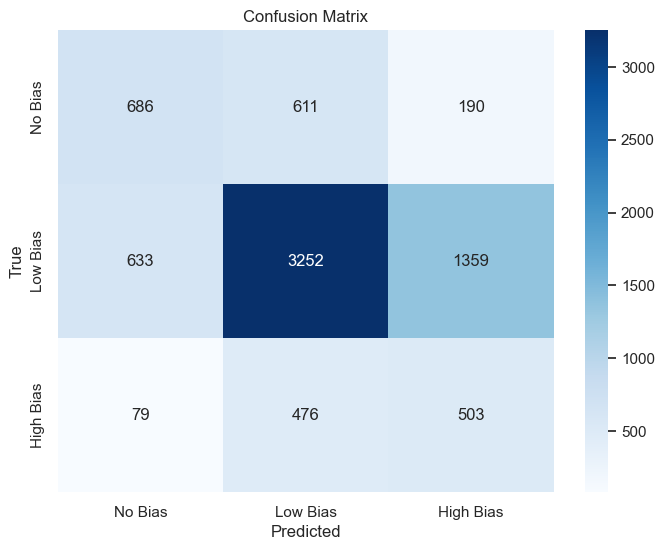

In [105]:
# Plotting the NN with Batch Normalization model confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(nn_model_4_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

We see above a mixed performance across bias classes. Recalling the classification report for our NN with Batch Normalization model, we see a reasonably high precision for "Low Bias" at 0.75, indicating that when it predicts instances as "Low Bias," it is accurate 75% of the time. However, precision is notably lower for "No Bias" at 0.25, indicating a higher rate of false positives for this class. The recall is relatively consistent across classes, with the model identifying around 46-62% of instances for "High Bias," "Low Bias," and "No Bias." 

The weighted average F1-Score of 59% shows a moderate-to-good overall balance between precision and recall. This is the model we recommend for further optimization.

## Technical Recommendations<a id='Recommendations'></a>
- **Continue to test NN with batch normalization model**, employing activation functions like LeakyReLU, and experimenting with different batch sizes, number of epochs, dropout rates & learning rates.
- **Try adding layers.**
- **Plot a loss function** to better understand the dynamics of the training process and make informed decisions about model's architecture

## Business Recommendations
### FairFrame: A Bias Mitigation Tool for Writers and Editors

PBS needs to back up its reputation as an objective American news source and defend itself against actors threatening to defund it on accusations of bias. In order to achieve this, we propose FairFrame - a simple app or pop-up browser extension — for writers and editors at PBS. This tool uses optimized neural networks identifying bias categories in headlines throughout the editorial process.

- **Headline Input:** Users can feed headlines into the tool for analysis.
- **Bias Categorization:** The tool employs a pretrained model to categorize the bias of the content into different levels (e.g., Neutral, Low Bias, High Bias).
- **Guided Editing Notes:** For content flagged with bias, the tool's various pre-loaded functions provide users with actionable and specific editing suggestions. For instance: "Consider neutralizing language in this sentence." OR "Use active voice for greater clarity and objectivity." OR "Adjust the tone to ensure a balanced representation."
- **User-Friendly Interface:** The tool features an intuitive and user-friendly interface, ensuring seamless integration into the editorial workflow.

**The Bottom Line:** FairFrame has the potential to enhance objectivity, empower writers and editors, hold all writers and editors to consistent standards, and promote efficient editing.

**Implementation**:
- Collaborate with machine learning experts to fine-tune the bias categorization model based on PBS's editorial guidelines.
- Conduct thorough training sessions for writers and editors to ensure effective utilization of the tool.
    
**Additional Recommendations:**
- Publish each article's headline bias score in plain view for readers to see
- Advertise and demonstrate the use and efficacy of FairFrame in public funding defense efforts

# Limitations and Further Inquiry<a id='Limitations and Further Inquiry'></a>

The scope and time constraints of the project limit our ability to explore other possible optimizations, activations, and other hyperparameters. To address this...
- **Explore more Recurrent Neural Networks like Bidirectional LSTM and Gated Recurrent Unit (GRU).**

The scope and time constraints of the project limit our ability to explore the dataframe's fullest modeling potential. To address this...
- **Invest in including some or all features engineered throughout our Feature Engineering (and more EDA) section.** We tried running comprehensive models using one or more of the engineered features, both one-hot-encoded categorical features and numerical features. It caused our models to run very slowly and in the interest of time and the scope of our project, we decided to leave it up to PBS to prepare and include them in future model iterations.
- **Merge other DataFrames from the broader data.world dataset (linked in dataset overview) to headlines.csv** and see what other comprehensive set of features can be gleaned.

Our data is highly imbalanced toward the Low Bias category. To address this...
- **Utilize the SMOTE library or a variant of it to address class imbalance head on.** These librares generate synthetic examples of the minority class to create a more balanced distribution and could lead to better optimized models.
- **Calculate class weights to customize to each individual model.**

Our dataset contains headlines from less-than-reputable news sources like people and abcnews. To address this...
- **Invest in collecting or utilizing existing PBS-specific headline data and/or other data from more reputable sources** to increase the relevance and efficacy of FairFrame. 